# Model Setup
Model 1 takes in img outputs moving probability
Model 2 takes in a sequence of 16 moving probs outputs falling probability

In [1]:
import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')
import tensorflow_datasets as tfds

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
import datetime
import cv2
import matplotlib.pyplot as plt

/home/jessica/VIA-Fall-Detection/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU limitation

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-07-06 10:55:17.818344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-06 10:55:17.955122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-06 10:55:17.955372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-06 10:55:17.992199: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Building the Model

### Train

In [2]:
default_data = np.loadtxt('defaultDiff.txt')
falling_data = np.loadtxt('fallingDiff.txt')

In [13]:
# limit = lambda x : max(min(x,1), 0)

def limit(x):
    if x > 1: return 1 - (x-1)
    elif x < 0: return abs(x)
    return x

newLimit = np.vectorize(limit)

def augment(less_data, copy_count):
    mu, sig = 0, 0.001
    rowi = 0
    for i in range(copy_count):
        # err = np.random.normal(mu, sig, 16)
        err = 0
        scale = 1
        row = less_data[rowi]*scale + err
        row = newLimit(row)

        less_data = np.vstack([less_data, row])
        rowi += 1
        if rowi >= len(less_data): rowi = 0

if copy_count < 0: # more falling, augment default
    augment(default_data, len(falling_data)-len(default_data))
else: # more default, augment falling
    augment(falling_data, len(default_data)-len(falling_data))

print(falling_data.shape, default_data.shape)

UnboundLocalError: local variable 'rowi' referenced before assignment

In [4]:
# loading data
inputs = np.concatenate((default_data, falling_data))
outputs = np.concatenate((np.zeros(len(default_data)), np.ones(len(falling_data)))) #ones are falling , zeros are default
dataset_size = len(inputs)
new_indices = np.random.permutation(dataset_size) # shuffle indices to shuffle X and y at the same time
inputs, outputs = inputs[new_indices], outputs[new_indices]

train_size = int(0.8*dataset_size)
test_size = dataset_size - train_size

# train_data = tf.data.Dataset.from_tensor_slices((inputs[:train_size], outputs[:train_size])).batch(128)
X_train, y_train = inputs[:train_size], outputs[:train_size]
X_test, y_test = inputs[train_size:], outputs[train_size:]
print(X_test)

[[0.01008142 0.00948475 0.00846352 ... 0.00807133 0.00820587 0.00749681]
 [0.03055449 0.030283   0.03324558 ... 0.0254001  0.02659117 0.02742828]
 [0.00554213 0.0045231  0.00471165 ... 0.00522511 0.00513327 0.00532299]
 ...
 [0.00462176 0.00496219 0.00719323 ... 0.00059723 0.00169529 0.00017483]
 [0.02862113 0.04094159 0.03845083 ... 0.01153129 0.00986329 0.00756256]
 [0.02225148 0.0221605  0.02216079 ... 0.02236225 0.02105936 0.02133466]]


In [5]:
### generator
def shuffle_generator(image, label, seed):
    idx = np.arange(len(image))
    np.random.default_rng(seed).shuffle(idx)
    for i in idx:
        yield image[i], label[i]

def filter_generator(X, label, seed):
    for i in range(len(X)):
        if label[i] == 0 or max(X[i])-min(X[i]) > 1.6:
           yield X[i], label[i]

dataset = tf.data.Dataset.from_generator(
    shuffle_generator,
    args=[X_train, y_train, 42],
    output_signature=(
        tf.TensorSpec(shape=(16,), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.uint8)))

2023-07-07 09:12:04.394469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 09:12:04.417022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 09:12:04.417179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 09:12:04.417914: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(16,)),
    tf.keras.layers.Dense(128, activation='relu', input_shape=(16,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
#Tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
model.fit(x=X_train, y=y_train, validation_split=0.1, epochs=6,callbacks=[tensorboard_callback]) # if training data is np array
# model.fit(dataset, epochs=6, callbacks=[tensorboard_callback]) # if training data is tensor

Epoch 1/6


85/85 [==============================] - 0s 3ms/step - loss: 0.6360 - accuracy: 0.7171 - val_loss: 0.6055 - val_accuracy: 0.6967
Epoch 2/6
85/85 [==============================] - 0s 2ms/step - loss: 0.5818 - accuracy: 0.7253 - val_loss: 0.5960 - val_accuracy: 0.7000
Epoch 3/6
85/85 [==============================] - 0s 2ms/step - loss: 0.5691 - accuracy: 0.7260 - val_loss: 0.5829 - val_accuracy: 0.7000
Epoch 4/6
85/85 [==============================] - 0s 2ms/step - loss: 0.5560 - accuracy: 0.7264 - val_loss: 0.5656 - val_accuracy: 0.7000
Epoch 5/6
85/85 [==============================] - 0s 4ms/step - loss: 0.5388 - accuracy: 0.7260 - val_loss: 0.5457 - val_accuracy: 0.7000
Epoch 6/6
85/85 [==============================] - 0s 5ms/step - loss: 0.5199 - accuracy: 0.7260 - val_loss: 0.5257 - val_accuracy: 0.7000


### Plot Data

In [14]:
max_falling_data = np.amax(falling_data, axis=1)
max_default_data = np.amax(default_data, axis=1)
print(max(max(max_falling_data), max(max_default_data)))

min_falling_data = np.amin(falling_data, axis=1)
min_default_data = np.amin(default_data, axis=1)
print(min(min(min_falling_data), max(min_default_data)))

1.0
0.0


[0.49431278 0.3418346  0.22029072 0.17031528 0.12206428 0.23869242
 0.33383957 0.4415127  0.40936132 0.27114212 0.1744543  0.1180434
 0.088962   0.09269465 0.09478484 0.09055873]
[0.3418346  0.22029072 0.17031528 0.12206428 0.23869242 0.33383957
 0.4415127  0.40936132 0.27114212 0.1744543  0.1180434  0.088962
 0.09269465 0.09478484 0.09055873 0.09205585]
[0.22029072 0.17031528 0.12206428 0.23869242 0.33383957 0.4415127
 0.40936132 0.27114212 0.1744543  0.1180434  0.088962   0.09269465
 0.09478484 0.09055873 0.09205585 0.09248789]
[0.17031528 0.12206428 0.23869242 0.33383957 0.4415127  0.40936132
 0.27114212 0.1744543  0.1180434  0.088962   0.09269465 0.09478484
 0.09055873 0.09205585 0.09248789 0.09498739]
[0.12206428 0.23869242 0.33383957 0.4415127  0.40936132 0.27114212
 0.1744543  0.1180434  0.088962   0.09269465 0.09478484 0.09055873
 0.09205585 0.09248789 0.09498739 0.13809853]
[0.23869242 0.33383957 0.4415127  0.40936132 0.27114212 0.1744543
 0.1180434  0.088962   0.09269465 0.09

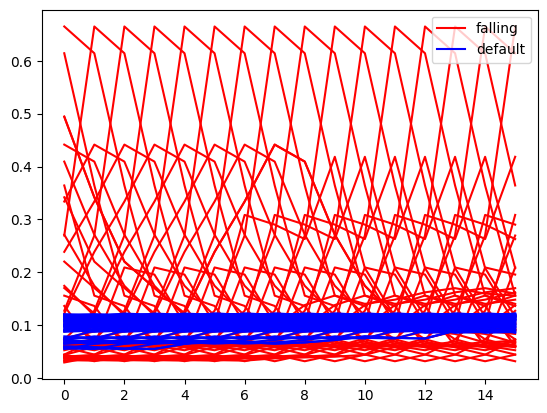

In [23]:
x = np.arange(16)
for r in range(50):
    y = falling_data[r]
    print(y)
    if r == 0: plt.plot(x,y,'r',label="falling")
    plt.plot(x,y,'r')

for r in range(50):
    y = default_data[r]
    if r == 0: plt.plot(x,y,'b',label="default")
    plt.plot(x,y,'b')
plt.legend()
plt.show()


### Evaluate & Export

In [30]:
loss, acc = model.evaluate(X_test, y_test)
# model.summary()
# model.save("new_model2")

40/40 [==============================] - 0s 991us/step - loss: 0.3782 - accuracy: 0.8485


In [8]:
### CONVERT TO TFLITE
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model2_tflite = converter.convert()
with open('new_model2.tflite', 'wb') as f: f.write(model2_tflite)

INFO:tensorflow:Assets written to: /tmp/tmpgy6fdty2/assets


2023-06-07 11:16:44.155686: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-06-07 11:16:44.445558: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-07 11:16:44.445580: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-07 11:16:44.446467: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpgy6fdty2
2023-06-07 11:16:44.447205: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-07 11:16:44.447233: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpgy6fdty2
2023-06-07 11:16:44.449735: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-06-07 11:16:44.489124: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on Saved

In [29]:
### QUANTIZE
def representative_dataset():
  for d in inputs:
    # d = np.expand_dims(d, axis=0)
    yield [tf.dtypes.cast(d, tf.float32)]

# print(dataset.cardinality().numpy())
# print(tf.shape(dataset))
# model.summary()

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_model2 = converter.convert()
with open('new_model2_quant', 'wb') as f: f.write(tflite_quant_model2)

INFO:tensorflow:Assets written to: /tmp/tmpdvgpu7f5/assets


INFO:tensorflow:Assets written to: /tmp/tmpdvgpu7f5/assets
/home/jessica/VIA-Fall-Detection/.venv/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-07 15:22:06.987031: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-06-07 15:22:06.987052: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-06-07 15:22:06.987225: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpdvgpu7f5
2023-06-07 15:22:06.987830: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-06-07 15:22:06.987841: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpdvgpu7f5
2023-06-07 15:22:06.989672: I tensorflow/cc/sav